# Preparation

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, cut_tree

from counterfactualgp.gp import GP
from counterfactualgp.mean import LinearWithBsplinesBasis
from counterfactualgp.treatment import DummyTreatment, Treatment
from counterfactualgp.mpp import BinaryActionModel
from counterfactualgp.cov import iid_cov, se_cov
from counterfactualgp.bsplines import BSplines
from counterfactualgp.lmm import LinearMixedModel, learn_lmm

In [2]:
with open('dataset/data_set_bspline_3classes.pkl', 'rb') as fin:
    data = pickle.load(fin)

In [3]:
low, high = 0.0, 24.0
num_basis = 5
bsplines_degree = 3
n_clusters = 3
basis = BSplines(low, high, num_basis, bsplines_degree, boundaries='space')

In [4]:
def predict(gp, y, x, x_star):
    t, rx = x
    t_star, rx_star = x_star
    yhat, cov_hat = gp.predict((t_star, rx_star), y, (t, rx))
        
    return yhat, cov_hat

In [5]:
def draw_bsplines(basis, coef, n_classes):
    t = np.linspace(basis._low, basis._high, num=100)

    fig, axes = plt.subplots(nrows=1, ncols=n_classes, sharey=True, figsize=(4*n_classes, 4))
    for i,w in enumerate(coef):
        y = np.dot(basis.design(t), w)
        if isinstance(axes, np.ndarray): 
            axes[i].plot(t, y)
        else:
            axes.plot(t, y)

    plt.show()

In [6]:
def draw_samples(gp, samples, t_star, rx_star, nrow=3, ncol=3, title='',
                 truncated_time=None, copy_truncated_rx=False):
    
    def _concat_x(t1, rx1, t2, rx2):
        t = np.concatenate([t1, t2])
        rx = np.concatenate([rx1, rx2])
        idx = np.argsort(t)
        return t[idx], rx[idx]
    
    # reset `rx_star` if not truncated
    if truncated_time is not None:
        rx_star[t_star <= truncated_time] = 0
    else:
        rx_star = np.zeros(rx_star.shape[0])
    
    fig, axes = plt.subplots(nrow, ncol, sharex=True, figsize=(12,6), sharey=True)
    for i in range(nrow):
        for j in range(ncol):
            idx = i*nrow+j            
            y, x = samples[idx]
            t, rx = x
            
            if truncated_time is not None:
                _y = y[t <= truncated_time]
                _t = t[t <= truncated_time]
                _rx = rx[t <= truncated_time]
                if copy_truncated_rx:
                    _t_star, _rx_star = _concat_x(t, rx, t_star, rx_star)
                else:
                    _t_star, _rx_star = _concat_x(_t, _rx, t_star, rx_star)
            else:
                _y, _t, _rx = y, t, rx
                _t_star, _rx_star = _concat_x(_t, _rx, t_star, rx_star)
            
            yhat, cov_hat = predict(gp, _y, (_t, _rx), (_t_star, _rx_star))
            y_std = np.diag(cov_hat)
            
            axes[i, j].plot(_t_star, yhat, color='b')
            axes[i, j].scatter(t, y, marker='o', color='r')
            for _tt, _rx in zip(t, rx):
                if _rx == 1:
                    axes[i, j].axvline(x=_tt, color = 'y')
            axes[i, j].fill_between(_t_star, yhat - y_std, yhat + y_std,
                                 alpha=0.2, color='k')
            if truncated_time is not None:
                axes[i, j].axvline(x=truncated_time, color='r', ls='--')
    fig.suptitle(title)
    plt.show()

# Clustering

In [7]:
def cluster_trajectories(data, xlim, basis, n_clusters, method='complete'):
    data = [(y, basis.design(x), basis.design(x)) for y,(x,_) in data]
    lmm = learn_lmm(data)
    
    beta, Sigma, v = lmm.param_copy()
    coef = np.array([lmm.posterior(*x)[0] for x in data])
    link = linkage(coef, method)
    clusters = cut_tree(link, n_clusters).ravel()
    cluster_coef = np.ndarray((n_clusters, coef.shape[1]))
    for k in range(n_clusters):
        w = coef[clusters == k].mean(axis=0)
        cluster_coef[k] = w
    
    fig, axes = plt.subplots(nrows=1, ncols=n_clusters, figsize=(4*n_clusters,4), sharex=True, sharey=True)
    t = np.linspace(low, high, num=100)
    for k in range(n_clusters):
        yhat = np.dot(basis.design(t), beta) + np.dot(basis.design(t), cluster_coef[k])
        axes[k].plot(t, yhat)
    plt.show()

    return cluster_coef

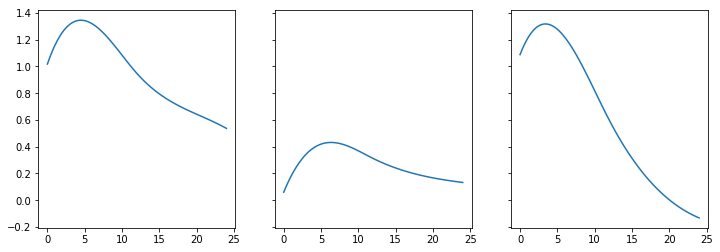

In [8]:
clustered_basis = cluster_trajectories(data['training2'], (low, high), basis, 3)

# Single GP

## Baseline GP without treatment

In [9]:
m = []
m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=0))
tr = []
tr.append( (1.0, DummyTreatment()) )
bgp = GP(m, se_cov(a=1.0, l=1.0), tr, ac_fn=None)
bgp.fit(data['training2'], init = False)
print(bgp.params)

obj= 5172.093505021836
obj= 5108.271061553546
obj= 5093.58607140126
obj= 5065.668715385415
obj= 4819.282659977127
obj= 4501.581462050775
obj= 4482.47337073403
obj= 4481.9286425267865
obj= 4481.866639475449
obj= 4481.842828021409
obj= 4481.8427795390635
obj= 4481.842779060398
obj= 4481.842779049519
obj= 4481.84277904949
{'ln_cov_l_F': array([0.]), 'classes_prob_logit_F': array([1.]), 'linear_with_bsplines_basis_mean_coef0': array([-4.96327757,  1.93202105,  0.29571435,  0.18211343,  0.36652357]), 'ln_cov_a_F': array([0.]), 'ln_cov_y': array([-2.29257482])}


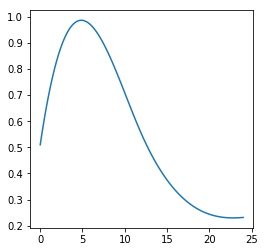

In [10]:
coef = [bgp.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

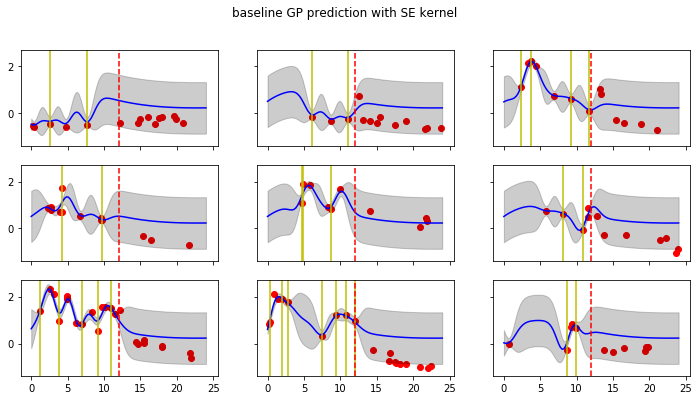

In [11]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel', data['truncated_time'])

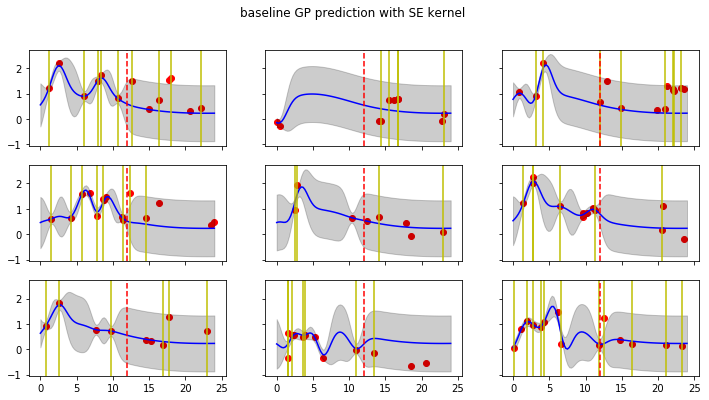

In [12]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel', 
             data['truncated_time'], copy_truncated_rx=True)

## Baseline GP with treatment

In [13]:
m = []
m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=0))
tr = []
tr.append( (1.0, Treatment(2.0)) )
bgp_rx = GP(m, se_cov(a=1.0, l=1.0), tr, ac_fn=None)
bgp_rx.fit(data['training2'], init = False)
print(bgp_rx.params)

obj= 5047.184530152005
obj= 3741.3515469505464
obj= 3721.45923858432
obj= 3721.179362199496
obj= 3720.691306813211
obj= 3716.768617507894
obj= 3713.9503774273344
obj= 3713.682329850303
obj= 3713.651926679141
obj= 3713.643495591339
obj= 3713.643088313294
obj= 3713.6430837186813
obj= 3713.6430836993277
obj= 3713.6430836987433
obj= 3713.6430836987383
{'ln_cov_l_F': array([0.]), 'effects_window_F': array([2.]), 'treatment': array([0.53047862]), 'classes_prob_logit_F': array([1.]), 'linear_with_bsplines_basis_mean_coef0': array([-1.63212877,  1.1783987 ,  0.12595539, -0.13996613, -0.12918574]), 'ln_cov_y': array([-2.94221228]), 'ln_cov_a_F': array([0.])}


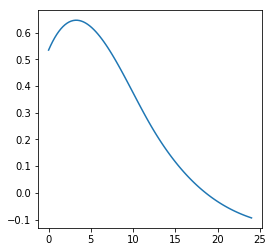

In [14]:
coef = [bgp_rx.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

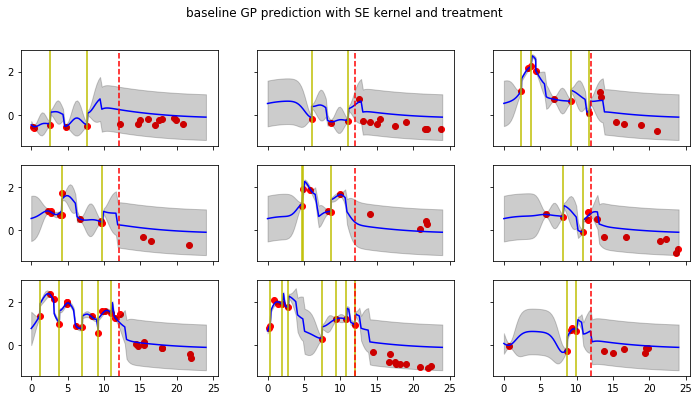

In [15]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp_rx, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'])

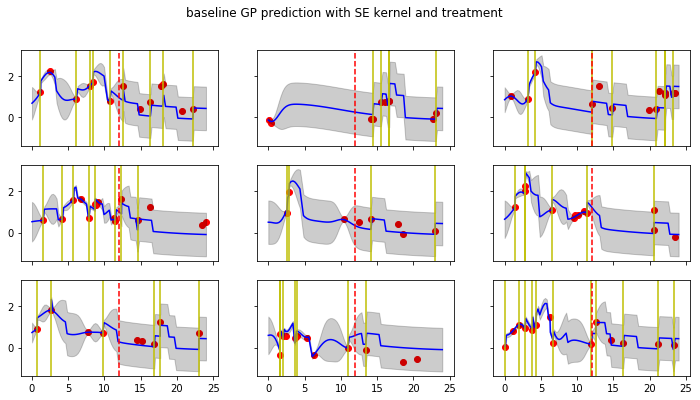

In [16]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(bgp_rx, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

## Counterfactual GP

In [17]:
m = []
m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=0))
tr = []
tr.append( (0.0, DummyTreatment()) )
tr.append( (1.0, Treatment(2.0)) )
ac = BinaryActionModel()
cgp = GP(m, se_cov(a=1.0, l=1.0), tr, ac_fn=ac)
cgp.fit(data['training2'], init = False)
print(cgp.params)

obj= [8060.46203138]
obj= [7488.38676326]
obj= [7356.48734348]
obj= [7334.35313593]
obj= [7319.74188348]
obj= [7198.81605311]
obj= [7014.42477714]
obj= [6872.83344874]
obj= [6870.78892778]
obj= [6870.61760698]
obj= [6870.58081517]
obj= [6870.57352752]
obj= [6870.57347566]
obj= [6870.57347518]
obj= [6870.57347516]
obj= [6870.57347516]
{'ln_cov_l_F': array([0.]), 'ln_cov_a_F': array([0.]), 'linear_with_bsplines_basis_mean_coef0': array([-2.11545859,  1.28354713,  0.11735672, -0.08626169, -0.36879375]), 'effects_window_F': array([2.]), 'treatment': array([0.60686055]), 'action': array([0.35276248]), 'classes_prob_logit_F': array([1.]), 'ln_cov_y': array([-3.06457102])}


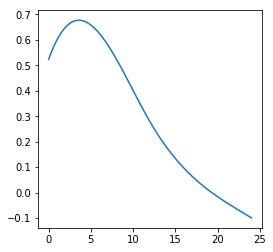

In [18]:
coef = [cgp.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

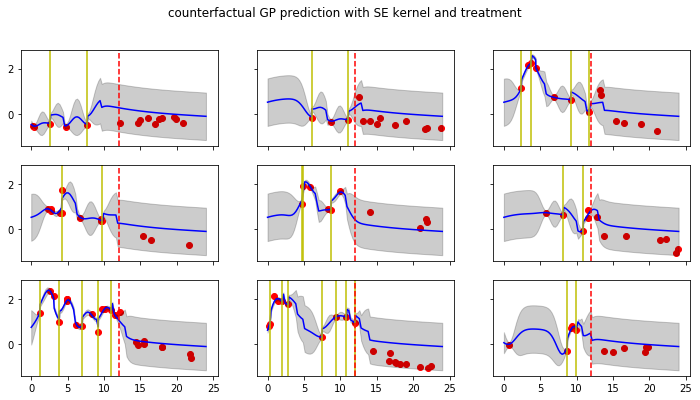

In [19]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(cgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'counterfactual GP prediction with SE kernel and treatment', 
             data['truncated_time'])

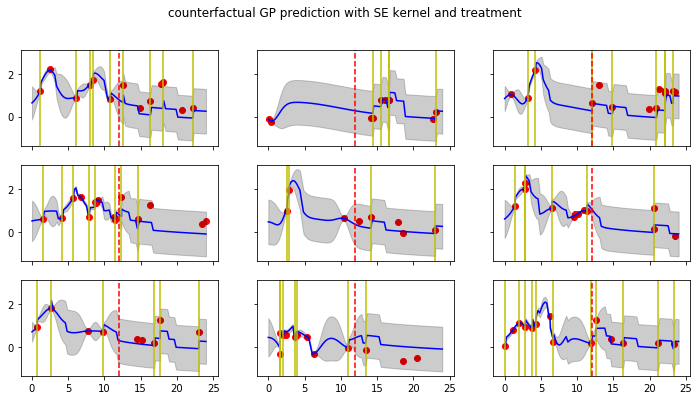

In [20]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))

draw_samples(cgp, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'counterfactual GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

# Mixture of GPs

## Mixture of BGPs without treatment

obj= 5186.4334470999065
obj= 5013.035622763831
obj= 4950.402816618208
obj= 4873.6029153932195
obj= 4832.653306710202
obj= 4763.598312880027
obj= 4644.485950588538
obj= 4587.63568485182
obj= 4560.110758093567
obj= 4522.845540405562
obj= 4491.231193638363
obj= 4483.7558776073365
obj= 4482.73964879222
obj= 4482.197452561246
obj= 4482.036271441764
obj= 4481.950996299513
obj= 4481.894030281708
obj= 4481.865919523198
obj= 4481.855598859623
obj= 4481.85064453998
obj= 4481.847028034042
obj= 4481.844804867999
obj= 4481.843881193155
obj= 4481.843469174446
obj= 4481.843176058861
obj= 4481.842972064366
obj= 4481.842877336555
obj= 4481.842837942235
obj= 4481.84281379109
obj= 4481.84279692564
obj= 4481.842788105021
obj= 4481.842784180289
obj= 4481.842781959288
obj= 4481.842780514118
obj= 4481.842779760406
obj= 4481.842779429354
obj= 4481.842779257027
obj= 4481.842779152769
obj= 4481.842779099049
obj= 4481.842779075347
obj= 4481.842779063398
obj= 4481.842779056418
obj= 4481.842779052825
{'classes_pro

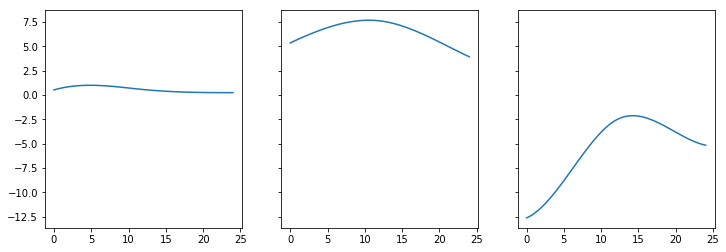

In [21]:
m = []
for i in range(n_clusters):
    m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=i, init=clustered_basis[i]))
tr = []
tr.append( (1.0, DummyTreatment()) )
mgp = GP(m, se_cov(a=1.0, l=1.0), tr, ac_fn=None)
mgp.fit(data['training2'], init = False)
print(mgp.params)

coef = [mgp.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

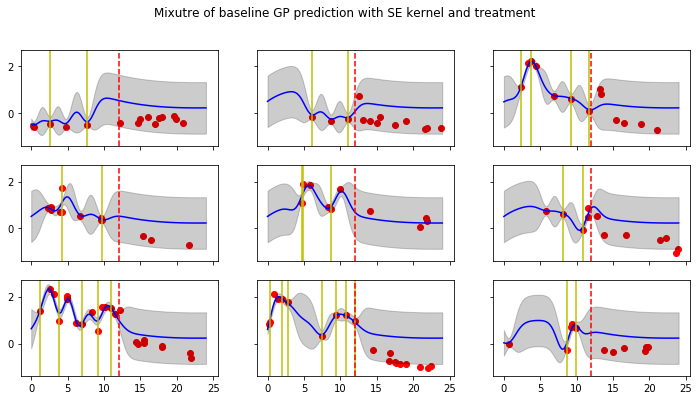

In [22]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'])

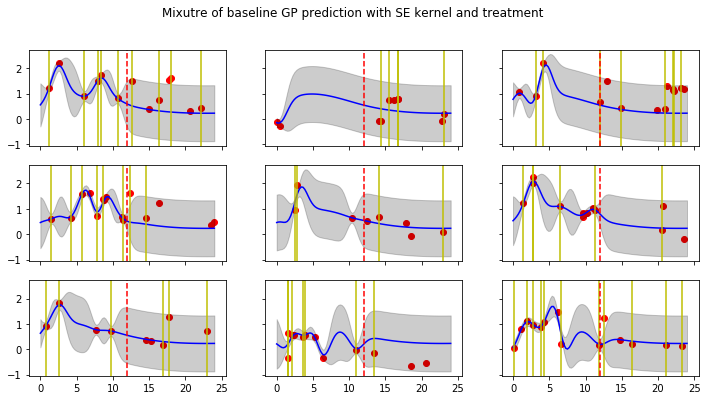

In [23]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mgp, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

## Mixture of BGPs with treatment

obj= 5001.382179142524
obj= 3822.1089839540523
obj= 3741.395101170374
obj= 3731.477209988143
obj= 3719.790189375066
obj= 3718.909303120423
obj= 3718.2997673866776
obj= 3717.3066545057895
obj= 3716.159698007916
obj= 3715.547460984018
obj= 3715.232056792234
obj= 3714.7416476431345
obj= 3714.5060412344064
obj= 3714.1403700023293
obj= 3713.837166268355
obj= 3713.7706641450927
obj= 3713.745542113421
obj= 3713.70753212897
obj= 3713.6839930993337
obj= 3713.6728091689097
obj= 3713.6560895315847
obj= 3713.648006855842
obj= 3713.6466006900428
obj= 3713.6449387264734
obj= 3713.644185014339
obj= 3713.6437276304464
obj= 3713.6435626108305
obj= 3713.643397712363
obj= 3713.6432586347173
obj= 3713.643176580327
obj= 3713.643136800206
obj= 3713.6431087758197
obj= 3713.6430904716267
obj= 3713.64308462915
obj= 3713.64308387558
obj= 3713.6430837869157
obj= 3713.6430837363578
obj= 3713.6430837114153
obj= 3713.643083705082
obj= 3713.6430837024445
obj= 3713.643083700084
obj= 3713.6430836989553
obj= 3713.64308

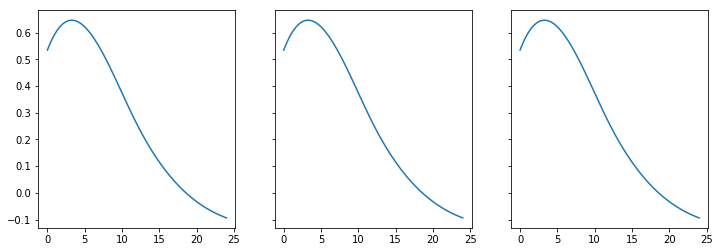

In [24]:
m = []
for i in range(n_clusters):
    m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=i, init=clustered_basis[i]))
tr = []
tr.append( (1.0, Treatment(2.0)) )
mgp_rx = GP(m, se_cov(a=1.0, l=1.0), tr, ac_fn=None)
mgp_rx.fit(data['training2'], init = False)
print(mgp_rx.params)

coef = [mgp_rx.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

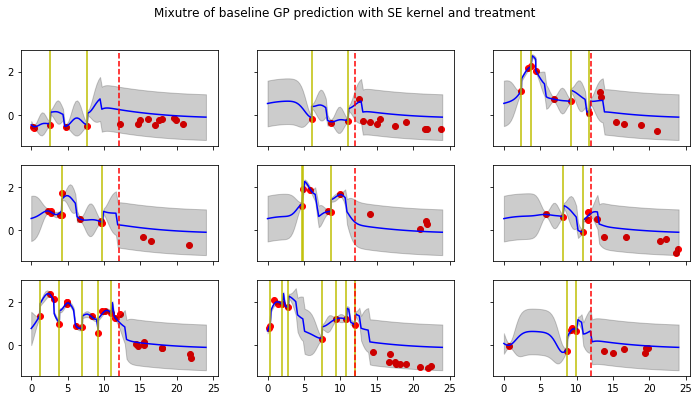

In [25]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mgp_rx, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'])

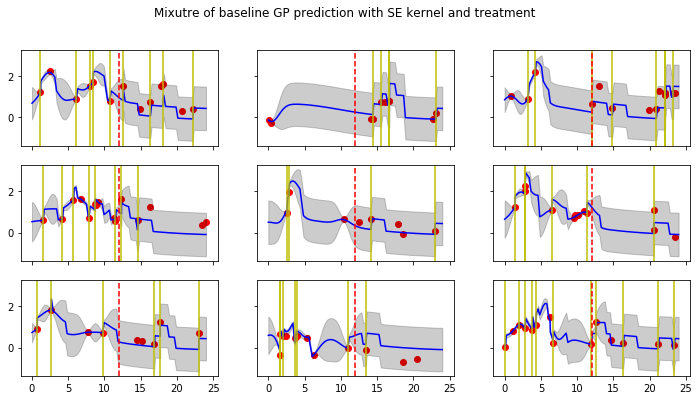

In [26]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mgp_rx, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of baseline GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

## Mixture of CGPs

obj= [8059.18053851]
obj= [7810.64381311]
obj= [7704.86543377]
obj= [7519.21709354]
obj= [7470.53150621]
obj= [7432.77955019]
obj= [7364.65539796]
obj= [7246.39026357]
obj= [7112.37287299]
obj= [7096.53691033]
obj= [7070.91220403]
obj= [7023.43860828]
obj= [7006.5100815]
obj= [6980.4227781]
obj= [6938.35710726]
obj= [6891.53752482]
obj= [6878.5124691]
obj= [6876.18972707]
obj= [6873.81285308]
obj= [6872.82631065]
obj= [6872.21727169]
obj= [6871.37744305]
obj= [6870.98386321]
obj= [6870.79636969]
obj= [6870.65348774]
obj= [6870.47782948]
obj= [6870.28832695]
obj= [6870.0562674]
obj= [6869.89574767]
obj= [6869.8545829]
obj= [6869.8178161]
obj= [6869.7984089]
obj= [6869.76531941]
obj= [6869.71392658]
obj= [6869.67109447]
obj= [6869.64979065]
obj= [6869.63388902]
obj= [6869.6296016]
obj= [6869.62202569]
obj= [6869.60974161]
obj= [6869.59428004]
obj= [6869.58243538]
obj= [6869.56581869]
obj= [6869.55988842]
obj= [6869.55852387]
obj= [6869.55790167]
obj= [6869.55762021]
obj= [6869.55730465]


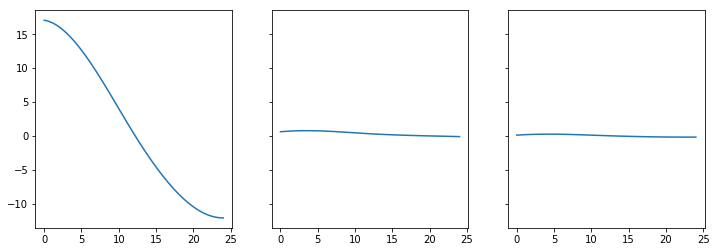

In [27]:
m = []
for i in range(n_clusters):
    m.append(LinearWithBsplinesBasis(num_basis, bsplines_degree, (low, high), no=i, init=clustered_basis[i]))
tr = []
tr.append( (0.0, DummyTreatment()) )
tr.append( (1.0, Treatment(2.0)) )
ac = BinaryActionModel()
mcgp = GP(m, se_cov(a=1.0, l=1.0), tr, ac_fn=ac)
mcgp.fit(data['training2'], init = False)
print(mcgp.params)

coef = [mcgp.params['linear_with_bsplines_basis_mean_coef{}'.format(no)] for no in range(len(m))]
draw_bsplines(basis, coef, len(m))

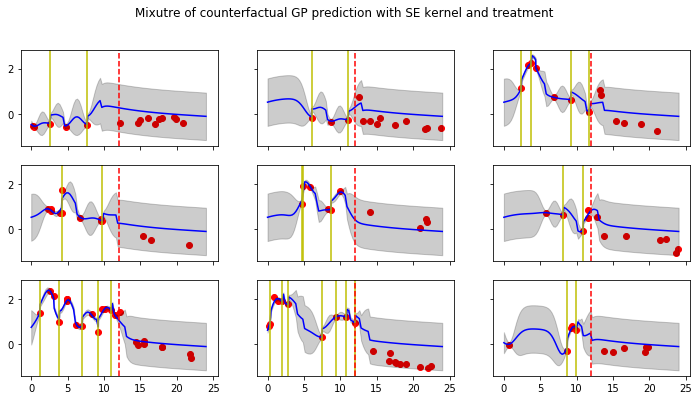

In [28]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mcgp, data['testing1'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of counterfactual GP prediction with SE kernel and treatment', 
             data['truncated_time'])

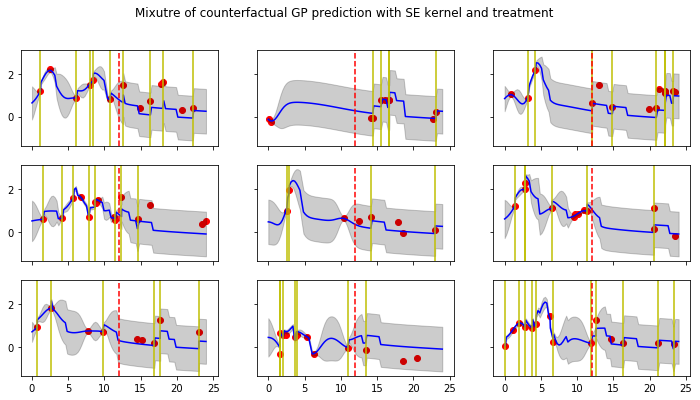

In [29]:
t_star = np.linspace(low, high, num = 100)
rx_star = np.zeros(len(t_star))
draw_samples(mcgp, data['training2'][0:9], t_star, rx_star, 
             3, 3, 'Mixutre of counterfactual GP prediction with SE kernel and treatment', 
             data['truncated_time'], copy_truncated_rx=True)

# MSE

In [30]:
def MSE(gp, samples, truncated_time):
    '''
    Calculate the MSE metric over points after `truncated_time`.
    '''
    s = 0.0
    for y, x in samples:
        t, rx = x
        idx = t <= truncated_time
        _y = y[idx]
        _t = t[idx]
        _rx = rx[idx]

        yhat, cov_hat = predict(gp, _y, (_t, _rx), (t, rx))
        s += np.sum((yhat[~idx] - y[~idx]) **2) / y[~idx].shape[0]
    
    return s / len(samples)

In [31]:
for s,gp in zip(['bgp', 'bgp_rx', 'cgp', 'mbgp', 'mbgp_rx', 'mcgp'], 
                 [bgp, bgp_rx, cgp, mgp, mgp_rx, mcgp]):
    print(s, MSE(gp, data['testing1'], data['truncated_time']))

bgp 0.3228047362339484
bgp_rx 0.17161638793099887
cgp 0.17912951635903324
mbgp 0.3228047545699727
mbgp_rx 0.1716163888009085
mcgp 0.17921137314099553


In [32]:
for s, gp in zip(['bgp', 'bgp_rx', 'cgp', 'mbgp', 'mbgp_rx', 'mcgp'], 
                 [bgp, bgp_rx, cgp, mgp, mgp_rx, mcgp]):
    print(s, MSE(gp, data['training2'], data['truncated_time']))

bgp 0.4009978541072844
bgp_rx 0.20507792162128607
cgp 0.24231523239629274
mbgp 0.4009978508690628
mbgp_rx 0.205077921422323
mcgp 0.2419220111960182
